# Variational Autoencoder with MSE as Reconstruction Loss Term

The motivating principle behind this experiment is that, while mathematically rigorous, the reconstruction likelihood loss function might be overly complex for the actual performance of VAE's for certain tasks. The true power of VAE's is their power to drive meaningful latent spaces by spreading the values out for a given input and in that way, the spaces in between each memorized point will be meaningful. 

This experiment hypothesizes that the VAE will perform better with a good ole fashioned MSE loss function as a reconstruction term so long as we keep the KL Divergence to drive the distribution of the latent layer to a standard normal. 


## Input info 

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])
raw_data = raw_data.loc[:, raw_data.columns != "timestamp"]
#make indices start at 0
raw_data["userId"] -= 1
raw_data["movieId"] -= 1
#make ratings center around 0
raw_data["rating"] -= 3

# create (943, 1682) matrix of user ratings per movie
user_ratings = pd.DataFrame(np.zeros((943,1682)))
for i in raw_data.index:
    user_ratings[raw_data["movieId"][i]][raw_data["userId"][i]] = raw_data["rating"][i]
user_ratings = user_ratings.to_numpy() 
np.random.shuffle(user_ratings)
user_ratings

C:\Users\leuch\AppData\Local\Temp\ipykernel_9064\2468113692.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Begin model and tuning of Hyperparameters

In [27]:
from torch.utils.data import Dataset, DataLoader
from torch import nn 
import torch
from sklearn.metrics import precision_recall_fscore_support
device = "cuda"

class MovielensDataset(Dataset):
    def __init__(self, data, mask_magnitude):
        self.data = data
        # create a mask of 0 and 1 values where half are 0 and half are 1. 
        #The ratio of masked values is something that can and should be optimized. 
        self.random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        np.random.shuffle(self.random_mask)
        return self.data[idx] * self.random_mask, self.data[idx]


class VariationalAutoEncoder(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.encoder = nn.Sequential(
            #Encoder
            nn.Linear(1682, 1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024,1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
        )
        self.decoder = nn.Sequential(
            #Decoder
            nn.Linear(512,1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024,1682),
            nn.Tanh()
        )
        # distribution parameters
        self.fc_mu = nn.Linear(1024, 512)
        self.fc_var = nn.Linear(1024, 512)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        #for evaluation purposes
        self.test_mse = 1000
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing data under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=1)
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def forward(self, x):
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        
        #perform the kernel trick to allow for backprop through sampling
        
        epsilon = torch.distributions.Normal(0, 1).rsample()
        z = mu + epsilon * std
        # decoded
        ratings = self.decoder(z) * 2
        return ratings, z, mu, std
    
    def vae_loss(self, x_hat, x, z, mu, std):
        # reconstruction loss. This is now MSE instead of gaussian likelihood
        indies = x.nonzero().split(1, dim=1)
        
        recon_loss = (x_hat * x).sum() /10
        #recon_loss = mse_loss_fcn(x_hat, x) * 10000#self.gaussian_likelihood(x_hat, self.log_scale, x)
        # kl
        kl = self.kl_divergence(z, mu, std)
        # elbo
        elbo = (kl - recon_loss).mean()

        return elbo

def train(dataloader, model,  optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        #compute prediction error
        pred, z, mu, std = model(X)
        loss = model.vae_loss(pred, y, z, mu, std)
        mse_loss = mse_loss_fcn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 and batch % 64 == 0:
            loss , current = loss.item(), (batch+1) * len(X)
            print("Epoch : " + str(epoch))
            print(f"loss: {loss:>7f}")
            print(f"MSE loss: {mse_loss:>7f}")
            losses.append(loss)
            mse_losses.append(mse_loss.item())

def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    num_batches= len(dataloader)
    model.eval()
    test_loss, correct, test_mse_loss = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            
            
            pred, z, mu, std = model(X)
            test_loss += model.vae_loss(pred, y, z, mu, std).item()
            test_mse_loss += mse_loss_fcn(pred, y)
    test_loss /= num_batches
    test_mse_loss /= num_batches
    if epoch % 100 ==0:
        test_losses.append(test_loss)
        #Come back and actually do the accuracy where it sees if it's at least on the right side of it or compute precision/recall or something like that
        print(f"Test Error: \n Avg Loss : {test_loss:>8f} ")
        print(f" Test MSE loss: {test_mse_loss:>7f}")
        test_mse_losses.append(test_mse_loss.item())
        model.test_mse = test_mse_loss.item()
        
        
        

## The actual search 
The following contains all of the logic you need to do to restart everything over so long as you've already loaded the ones above

In [28]:
epochs = 2000
lowest_test_mse_score = 1000
mask_magnitude = 1.3
#Search 
l2_weight = 0
dropout_rate = 0
random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
print("using hyperparameters : " + str( l2_weight) + " , " + str(dropout_rate))
train_dataset = MovielensDataset(user_ratings[:843], mask_magnitude)
test_dataset = MovielensDataset(user_ratings[843:], mask_magnitude)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)


losses = []
mse_losses = []    
test_losses = []
test_mse_losses = []

model = VariationalAutoEncoder(dropout_rate = dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = l2_weight)
mse_loss_fcn = nn.MSELoss()

for t in range(epochs):
    train(train_dataloader, model,  optimizer, t)
    test(test_dataloader, model, t )
    if t % 100 == 0:
        if model.test_mse < lowest_test_mse_score:
            lowest_test_mse_score = model.test_mse
            torch.save(model.state_dict(), "./models/best.pth")
            print("New best using hyper parameters : " + str(mask_magnitude) + " ," + str(l2_weight) + " ," + str(dropout_rate)  )

using hyperparameters : 0 , 0
Epoch : 0
loss: -3.598530
MSE loss: 0.465652
Test Error: 
 Avg Loss : -668.407471 
 Test MSE loss: 1.193880
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 100
loss: -1118.517334
MSE loss: 3.298848
Test Error: 
 Avg Loss : -1533.313721 
 Test MSE loss: 3.436263
Epoch : 200
loss: -1002.020630
MSE loss: 3.543396
Test Error: 
 Avg Loss : -1570.069824 
 Test MSE loss: 3.461957
Epoch : 300
loss: -925.441101
MSE loss: 3.425423
Test Error: 
 Avg Loss : -1555.445312 
 Test MSE loss: 3.493355
Epoch : 400
loss: -1107.899170
MSE loss: 3.507776
Test Error: 
 Avg Loss : -1552.439453 
 Test MSE loss: 3.404649
Epoch : 500
loss: -928.997314
MSE loss: 3.520913
Test Error: 
 Avg Loss : -1583.646729 
 Test MSE loss: 3.387106
Epoch : 600
loss: -1049.870361
MSE loss: 3.517392
Test Error: 
 Avg Loss : -1582.577148 
 Test MSE loss: 3.387108
Epoch : 700
loss: -1003.708923
MSE loss: 3.557987
Test Error: 
 Avg Loss : -1587.404663 
 Test MSE loss: 3.426659
Epoch : 800
loss: -139

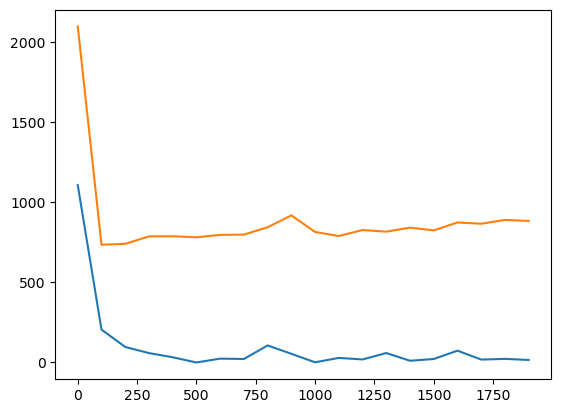

In [16]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)) * 100, losses)
plt.plot(np.arange(len(test_losses)) * 100, test_losses)

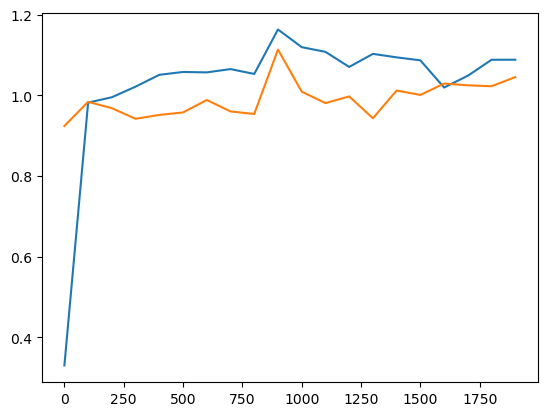

In [15]:
plt.plot(np.arange(len(mse_losses)) * 100, np.sqrt(np.array(mse_losses)))
plt.plot(np.arange(len(test_mse_losses)) * 100, np.sqrt(np.array(test_mse_losses)))

In [29]:
model = VariationalAutoEncoder(dropout_rate = 0).to(device)
model.load_state_dict(torch.load("./models/best.pth"))
model.eval()


VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1682, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1024, out_features=1682, bias=True)
    (4): Tanh()
  )
  (fc_mu): Linear(in_features=1024, out_features=512, bias=True)
  (fc_var): Linear(in_features=1024, out_features=512, bias=True)
)

In [32]:
relevance_labels = user_ratings[843:] > 0.5
#To evaluate for comparison to other papers we mask by setting 20% of labels to false 
test_inputs = np.clip((np.random.randn(1682) + 1.35).round(), a_max = 1, a_min = 0) * user_ratings[843:]
test_preds = model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0] > 0.4

precision_recall_fscore_support(relevance_labels.flatten(), test_preds.cpu().flatten(), average="binary")

(0.09248425847363015, 0.3123209169054441, 0.14270948180815876, None)

## Conclusion:
The result is that I was, in fact, mistaken and that the MSE was less suited to the task than the usual Gaussian Likelihood

(array([[  0.,   0.,   0., ..., 100.,   0.,   0.],
        [  0.,   0.,  93., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-1.75297892, -1.39329898, -1.03361905, -0.67393905, -0.31425908,
         0.04542089,  0.40510085,  0.76478082,  1.12446082,  1.48414075,
         1.84382069]),
 <a list of 1682 BarContainer objects>)

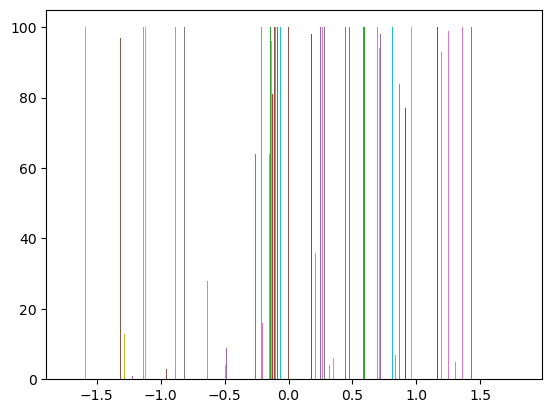

In [13]:
import matplotlib.pyplot as plt
plt.hist(model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0].cpu().detach().numpy())

In [102]:
model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0].max()

tensor(0.8346, device='cuda:0', grad_fn=<MaxBackward1>)